## Data Source : https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis


In [73]:
conda install seaborn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

import plotly as py
import plotly.graph_objs as go

from datetime import datetime
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

In [3]:
# Define the color palette 
Viridis=[
"#440154", "#440558", "#450a5c", "#450e60", "#451465", "#461969",
"#461d6d", "#462372", "#472775", "#472c7a", "#46307c", "#45337d",
"#433880", "#423c81", "#404184", "#3f4686", "#3d4a88", "#3c4f8a",
"#3b518b", "#39558b", "#37598c", "#365c8c", "#34608c", "#33638d",
"#31678d", "#2f6b8d", "#2d6e8e", "#2c718e", "#2b748e", "#29788e",
"#287c8e", "#277f8e", "#25848d", "#24878d", "#238b8d", "#218f8d",
"#21918d", "#22958b", "#23988a", "#239b89", "#249f87", "#25a186",
"#25a584", "#26a883", "#27ab82", "#29ae80", "#2eb17d", "#35b479",
"#3cb875", "#42bb72", "#49be6e", "#4ec16b", "#55c467", "#5cc863",
"#61c960", "#6bcc5a", "#72ce55", "#7cd04f", "#85d349", "#8dd544",
"#97d73e", "#9ed93a", "#a8db34", "#b0dd31", "#b8de30", "#c3df2e",
"#cbe02d", "#d6e22b", "#e1e329", "#eae428", "#f5e626", "#fde725"]
# source: https://bhaskarvk.github.io/colormap/reference/colormap.html

## Decision Trees with Scikit learn

## Import Data


In [4]:
market_df = pd.read_csv('data/marketing_campaign.csv')
market_df.shape

(2240, 29)

## Explore data
- Transform cols
- Drop cols


In [5]:
market_df.head(2)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0


In [6]:
# Change birth year to age, customer date to years

def years_customer(inp_date):
    format_Dt = pd.to_datetime(inp_date, format="%d-%m-%Y")
    today = datetime.today()
    return today.year - format_Dt.year - ((today.month, today.day) < (format_Dt.month, format_Dt.day))

market_df['Yrs_Customer'] = market_df['Dt_Customer'].apply(lambda x: years_customer(x))

market_df['age'] = 2022 - market_df['Year_Birth']

market_df.drop(columns=['Z_CostContact','Z_Revenue','Dt_Customer','Year_Birth', 'Complain', 'ID'], inplace=True)

market_df.head(2)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Yrs_Customer,age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,4,7,0,0,0,0,0,1,9,65
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,2,5,0,0,0,0,0,0,8,68


In [7]:
# calculate total amount spent, drop inidvidual cols.

#market_df['MntSpent'] = market_df['MntWines'] + market_df['MntFruits'] +market_df['MntMeatProducts'] + market_df['MntFishProducts'] +market_df['MntSweetProducts'] + market_df['MntGoldProds']
#market_df.drop(columns=['MntWines','MntFruits','MntMeatProducts','MntFishProducts', 'MntSweetProducts', 'MntGoldProds'], inplace=True)
market_df.head(2)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Yrs_Customer,age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,4,7,0,0,0,0,0,1,9,65
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,2,5,0,0,0,0,0,0,8,68


In [8]:
#market_df['PriorCampaign']=np.where((market_df['AcceptedCmp1']==1)|(market_df['AcceptedCmp2']==1)|(market_df['AcceptedCmp3']==1)|(market_df['AcceptedCmp4']==1)|(market_df['AcceptedCmp5']==1), 1, 0) # Accepted any campaign
#market_df['PriorCampaign']=market_df['AcceptedCmp5']
#market_df.drop(columns=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4', 'AcceptedCmp5'], inplace=True)
market_df.head(2)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Yrs_Customer,age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,4,7,0,0,0,0,0,1,9,65
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,2,5,0,0,0,0,0,0,8,68


In [9]:
#market_df['NumPurchases'] = market_df['NumDealsPurchases'] + market_df['NumWebPurchases'] +market_df['NumCatalogPurchases'] + market_df['NumStorePurchases']
#market_df.drop(columns=['NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases'], inplace=True)
market_df.head(2)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Yrs_Customer,age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,4,7,0,0,0,0,0,1,9,65
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,2,5,0,0,0,0,0,0,8,68


In [10]:
test_df = market_df

# create dummy variables
#test_df = pd.get_dummies(market_df)
#test_df.head()


In [11]:
test_df.head(1)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Yrs_Customer,age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,4,7,0,0,0,0,0,1,9,65


## Cleaning

In [12]:
test_df.isnull().sum()

Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Yrs_Customer            0
age                     0
dtype: int64

In [13]:
# replace the missing Income values with the mean
test_df['Income'].fillna(test_df['Income'].mean(), inplace=True)

## Use Onehot encoder and label encoder

In [14]:
# Create label encoder instance
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lb = LabelEncoder() 

In [15]:
# others
test_df['Education_'] = lb.fit_transform(test_df['Education']) 
test_df['Marital_Status_'] = lb.fit_transform(test_df['Marital_Status'] ) 

In [16]:
test_df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Yrs_Customer,age,Education_,Marital_Status_
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,1,9,65,2,4
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,0,8,68,2,4
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,0,8,57,2,5
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,0,8,38,2,5
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,0,8,41,4,3


# Set training data


In [17]:
# Assign feature and target variables
X = test_df.drop(columns=['Response','Education','Marital_Status'], axis=1)
y = test_df['Response']


In [18]:
# split the  data
X_train, X_test , y_train,y_test = train_test_split(X, y, test_size = 0.4, random_state = 42) 

## Split the pandas dummy data
#X_train, X_test , y_train,y_test = train_test_split(X_dummy, y, test_size = 0.4, random_state = 42) 



# Build Decision Tree

In [21]:
# Instantiate
SEED = 1
clf= DecisionTreeClassifier(criterion='entropy', random_state=SEED)
# clf= DecisionTreeClassifier(criterion='gini')

# Fit the model
clf.fit(X_train,y_train) 

# Generate inferences
y_pred = clf.predict(X_test)

In [22]:
# compare predictions vs. actual labels
print(list(y_pred))
print(list(y_test))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 

# Evaluate Model Performance

In [23]:
# Look at feature importance
print(len(clf.feature_importances_))

clf.feature_importances_

24


array([0.04663905, 0.00441135, 0.00408585, 0.14075764, 0.04987423,
       0.04194931, 0.08862043, 0.0315458 , 0.03465752, 0.04296076,
       0.01931653, 0.01795175, 0.02423   , 0.0258986 , 0.05031402,
       0.05207116, 0.005933  , 0.11281178, 0.04114893, 0.00495222,
       0.05149246, 0.05672693, 0.0249734 , 0.02667729])

In [24]:
## put feature importance into a dataframe - uncomment only one statement below.

# use this if you used the one-hot encoded data
fi = pd.DataFrame({'feature':X.columns, 'importance':clf.feature_importances_})
fi=fi.set_index('feature')
fi

,importance
feature,
Income,0.046639
Kidhome,0.004411
Teenhome,0.004086
Recency,0.140758
MntWines,0.049874
MntFruits,0.041949
MntMeatProducts,0.088620
MntFishProducts,0.031546
MntSweetProducts,0.034658


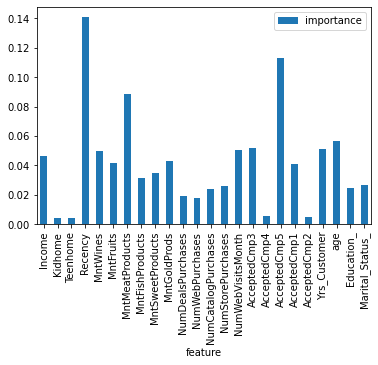

In [25]:
fi.plot(kind='bar');

In [26]:
# look at the class balance again.
y_train.value_counts(normalize=True)

0    0.845982
1    0.154018
Name: Response, dtype: float64

In [27]:
# Baseline model is defined by the most frequent class in our training data

y_baseline = y_train.value_counts().index[0]
baseline_acc = round(y_train.value_counts(normalize=True)[y_baseline]*100,2)
print(f'Most Frequent Category: {y_baseline}')
print(f'Percentage Most Frequent Category: {baseline_acc}%')

Most Frequent Category: 0
Percentage Most Frequent Category: 84.6%


In [28]:
# Calculate Accuracy , AUC and Confusion matrix 
accuracy = accuracy_score(y_test, y_pred)
accuracy


0.8325892857142857

In [29]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[703,  66],
       [ 84,  43]])

In [30]:
# get roc auc info
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

In [31]:
print("Accuracy is : "+ str(round(accuracy,3)*100)+"%")
print("AUC is : "+str(round(roc_auc,3)))

Accuracy is : 83.3%
AUC is : 0.626


# Plot ROC

Test AUC: 0.6263784647205185


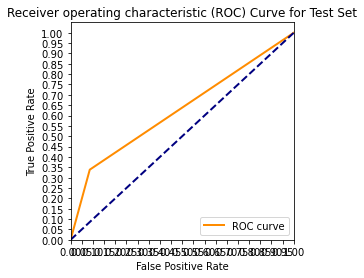

In [32]:
# Plot the ROC 
plt.figure(figsize=(4,4))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [33]:
## Compute other confusion matrix metrics

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [34]:
#precision 

precision = tp/(tp+fp)
precision

0.3944954128440367

In [35]:
# Sensitivity (recall) tp/(tp+fn)
sensitivity = tp/(tp+fn)
sensitivity

0.33858267716535434

In [36]:

# Specificity tn/(tn+fp)
specificity = tn/(tn+fp)
specificity

0.9141742522756827

In [37]:
# false negative rate (miss rate) fn/(fn+tp)
fnr = fn/(fn+tp)
fpr = fp/(fp+tn)

In [38]:
print(f'precision: {precision}')
print(f'sensitivity: {sensitivity}')
print(f'specificity: {specificity}')

# f1 score - (2*tp)/(2*tp+fp+fn))
f1 = (2*tp)/(2*tp+fp+fn)
print(f'f1: {f1}')


print(f'fnr: {fnr}')
print(f'fpr: {fpr}')


precision: 0.3944954128440367
sensitivity: 0.33858267716535434
specificity: 0.9141742522756827
f1: 0.3644067796610169
fnr: 0.6614173228346457
fpr: 0.0858257477243173


In [39]:
clf_report =   classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       769
           1       0.39      0.34      0.36       127

    accuracy                           0.83       896
   macro avg       0.64      0.63      0.63       896
weighted avg       0.82      0.83      0.83       896



# Maximum Tree depth

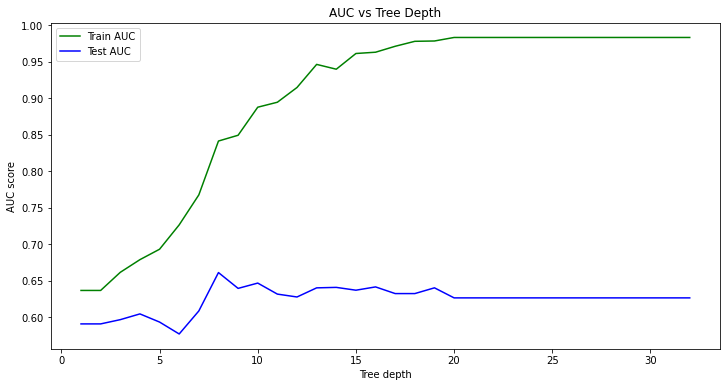

In [40]:
# Identify the optimal tree depth for given data

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'g', label='Train AUC')
plt.plot(max_depths, test_results, 'b', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.title("AUC vs Tree Depth")
plt.legend()
plt.show()

In [41]:
# Maximum Sample Split

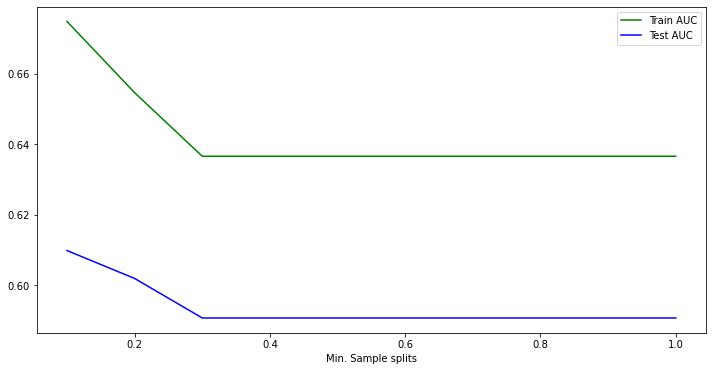

In [42]:
# Identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'g', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'b', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

# Minimum Sample Leafs

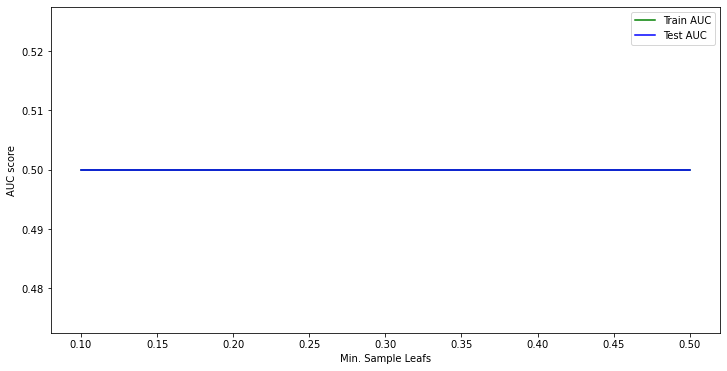

In [48]:
# Calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'g', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'b', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

# Maximum Features

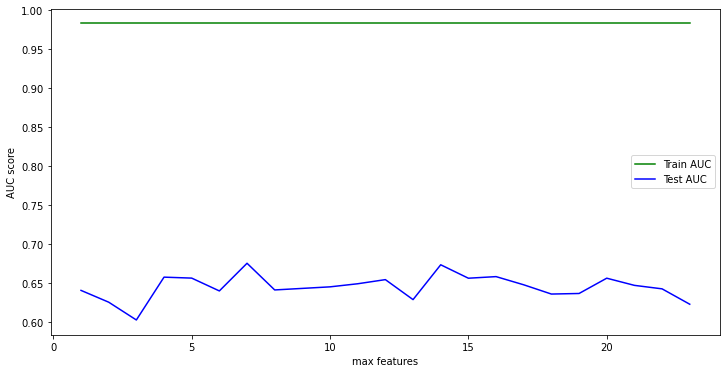

In [49]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=SEED)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'g', label='Train AUC')
plt.plot(max_features, test_results, 'b', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

## Re-train the classifier with chosen values

In [50]:
# train a classifier with optimal values identified above

dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=14,
                           max_depth=7,
                           min_samples_split=0.1,
                           min_samples_leaf=0.30, 
                           random_state=SEED)
dt.fit(X_train, y_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6224414568465029

In [51]:
# Calculate Accuracy , AUC and Confusion matrix 
accuracy = accuracy_score(y_test, y_pred)

# get roc auc info
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("Accuracy is : "+ str(round(accuracy,3)*100)+"%")
print("AUC is : "+str(round(roc_auc,3)))

# confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy is : 83.1%
AUC is : 0.622
Confusion Matrix:
[[703  66]
 [ 85  42]]


# Classification
- Convert values into ranges

In [373]:
df = market_df

In [374]:
# Age
bins=[1, 20, 28, 38, 80]
df['age_binned']=pd.cut(df['age'], bins)
df['age_binned'].value_counts().sort_index()

(1, 20]        0
(20, 28]      10
(28, 38]     247
(38, 80]    1954
Name: age_binned, dtype: int64

In [375]:
df = pd.get_dummies(df, prefix='Age', prefix_sep=' ', columns=['age_binned'])
df.head(2)


,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,PriorCampaign,NumPurchases,Children,"Age (1, 20]","Age (20, 28]","Age (28, 38]","Age (38, 80]"
0,5524,Graduate,Single,58138.0,58,7,1,9,65,1617,0,25,0,0,0,0,1
1,2174,Graduate,Single,46344.0,38,5,0,8,68,27,0,6,1,0,0,0,1


In [376]:
df['Marital_Status']=np.where((df['Marital_Status']=='Relationship'), 1, 0)
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,PriorCampaign,NumPurchases,Children,"Age (1, 20]","Age (20, 28]","Age (28, 38]","Age (38, 80]"
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,0,25,0,0,0,0,1
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,0,6,1,0,0,0,1


In [377]:
df['UnderGraduate']=np.where((df['Education']=='Under Graduate'), 1, 0)
df['Graduate']=np.where((df['Education']== 'Graduate'), 1, 0)
df['PostGraduate']=np.where((df['Education']=='Post Graduate'), 1, 0)
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,PriorCampaign,NumPurchases,Children,"Age (1, 20]","Age (20, 28]","Age (28, 38]","Age (38, 80]",UnderGraduate,Graduate,PostGraduate
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,0,25,0,0,0,0,1,0,1,0
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,0,6,1,0,0,0,1,0,1,0


In [378]:
# Income
(df.Income.describe())

count      2213.000000
mean      52236.581563
std       25178.603047
min        1730.000000
25%       35246.000000
50%       51373.000000
75%       68487.000000
max      666666.000000
Name: Income, dtype: float64

In [379]:
bins=[1, 10000, 25000, 50000, 75000, 670000]
df['Income_binned']=pd.cut(df['Income'], bins)
df['Income_binned'].value_counts().sort_index()

(1, 10000]          29
(10000, 25000]     213
(25000, 50000]     817
(50000, 75000]     796
(75000, 670000]    358
Name: Income_binned, dtype: int64

In [380]:
df = pd.get_dummies(df, prefix='Income', prefix_sep=' ', columns=['Income_binned'])
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,...,"Age (28, 38]","Age (38, 80]",UnderGraduate,Graduate,PostGraduate,"Income (1, 10000]","Income (10000, 25000]","Income (25000, 50000]","Income (50000, 75000]","Income (75000, 670000]"
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,...,0,1,0,1,0,0,0,0,1,0
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,...,0,1,0,1,0,0,0,1,0,0


In [381]:
# Recency
(df.Recency.describe())

count    2213.000000
mean       49.007682
std        28.941864
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Recency, dtype: float64

In [382]:
bins=[0, 35, 65, 100]
df['Recency_binned']=pd.cut(df['Recency'], bins)
df['Recency_binned'].value_counts().sort_index()

(0, 35]      785
(35, 65]     667
(65, 100]    733
Name: Recency_binned, dtype: int64

In [383]:
df = pd.get_dummies(df, prefix='Recency', prefix_sep=' ', columns=['Recency_binned'])
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,...,Graduate,PostGraduate,"Income (1, 10000]","Income (10000, 25000]","Income (25000, 50000]","Income (50000, 75000]","Income (75000, 670000]","Recency (0, 35]","Recency (35, 65]","Recency (65, 100]"
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,...,1,0,0,0,0,1,0,0,1,0
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,...,1,0,0,0,1,0,0,0,1,0


In [384]:
# MntSpent
(df.MntSpent.describe())

count    2213.000000
mean      607.021690
std       602.488663
min         5.000000
25%        69.000000
50%       397.000000
75%      1048.000000
max      2525.000000
Name: MntSpent, dtype: float64

In [385]:
bins=[0, 600, 1200, 1800, 2600]
df['MntSpent_binned']=pd.cut(df['MntSpent'], bins)
df['MntSpent_binned'].value_counts().sort_index()

(0, 600]        1301
(600, 1200]      499
(1200, 1800]     311
(1800, 2600]     102
Name: MntSpent_binned, dtype: int64

In [386]:
df = pd.get_dummies(df, prefix='MntSpent', prefix_sep=' ', columns=['MntSpent_binned'])
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,...,"Income (25000, 50000]","Income (50000, 75000]","Income (75000, 670000]","Recency (0, 35]","Recency (35, 65]","Recency (65, 100]","MntSpent (0, 600]","MntSpent (600, 1200]","MntSpent (1200, 1800]","MntSpent (1800, 2600]"
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,...,0,1,0,0,1,0,0,0,1,0
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,...,1,0,0,0,1,0,1,0,0,0


In [387]:
# Webvisits
(df.NumWebVisitsMonth.describe())

count    2213.000000
mean        5.321735
std         2.425092
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: NumWebVisitsMonth, dtype: float64

In [388]:
bins=[0, 5, 10, 15, 20]
df['WebVisits_binned']=pd.cut(df['NumWebVisitsMonth'], bins)
df['WebVisits_binned'].value_counts().sort_index()

(0, 5]      1047
(5, 10]     1147
(10, 15]       3
(15, 20]       6
Name: WebVisits_binned, dtype: int64

In [389]:
df = pd.get_dummies(df, prefix='NumWebVisitsMonth', prefix_sep=' ', columns=['WebVisits_binned'])
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,...,"Recency (35, 65]","Recency (65, 100]","MntSpent (0, 600]","MntSpent (600, 1200]","MntSpent (1200, 1800]","MntSpent (1800, 2600]","NumWebVisitsMonth (0, 5]","NumWebVisitsMonth (5, 10]","NumWebVisitsMonth (10, 15]","NumWebVisitsMonth (15, 20]"
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,...,1,0,0,0,1,0,0,1,0,0
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,...,1,0,1,0,0,0,1,0,0,0


In [390]:
# Yrs Customer
(df.Yrs_Customer.describe())

count    2213.000000
mean        8.366923
std         0.589257
min         7.000000
25%         8.000000
50%         8.000000
75%         9.000000
max         9.000000
Name: Yrs_Customer, dtype: float64

In [391]:
df['CustYrsMoreThan7']=np.where((df['Yrs_Customer']> 7), 1, 0)
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,...,"Recency (65, 100]","MntSpent (0, 600]","MntSpent (600, 1200]","MntSpent (1200, 1800]","MntSpent (1800, 2600]","NumWebVisitsMonth (0, 5]","NumWebVisitsMonth (5, 10]","NumWebVisitsMonth (10, 15]","NumWebVisitsMonth (15, 20]",CustYrsMoreThan7
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,...,0,0,0,1,0,0,1,0,0,1
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,...,0,1,0,0,0,1,0,0,0,1


In [392]:
# Num Purchases
(df.NumPurchases.describe())

count    2213.000000
mean       14.889742
std         7.670341
min         0.000000
25%         8.000000
50%        15.000000
75%        21.000000
max        44.000000
Name: NumPurchases, dtype: float64

In [393]:
bins=[0, 25, 50]
df['NumPurchases_binned']=pd.cut(df['NumPurchases'], bins)
df['NumPurchases_binned'].value_counts().sort_index()

(0, 25]     2004
(25, 50]     205
Name: NumPurchases_binned, dtype: int64

In [394]:
df = pd.get_dummies(df, prefix='NumPurchases', prefix_sep=' ', columns=['NumPurchases_binned'])
df.head(2)

,ID,Education,Marital_Status,Income,Recency,NumWebVisitsMonth,Response,Yrs_Customer,age,MntSpent,...,"MntSpent (600, 1200]","MntSpent (1200, 1800]","MntSpent (1800, 2600]","NumWebVisitsMonth (0, 5]","NumWebVisitsMonth (5, 10]","NumWebVisitsMonth (10, 15]","NumWebVisitsMonth (15, 20]",CustYrsMoreThan7,"NumPurchases (0, 25]","NumPurchases (25, 50]"
0,5524,Graduate,0,58138.0,58,7,1,9,65,1617,...,0,1,0,0,1,0,0,1,1,0
1,2174,Graduate,0,46344.0,38,5,0,8,68,27,...,0,0,0,1,0,0,0,1,1,0


In [395]:
df.head(1).T

,0
ID,5524
Education,Graduate
Marital_Status,0
Income,58138.0
Recency,58
NumWebVisitsMonth,7
Response,1
Yrs_Customer,9
age,65
MntSpent,1617


In [396]:
feature_cols=list(df.columns)
for item in ['age',  'Age (1, 20]', 'Education', 'Income', 'Recency', 'NumWebVisitsMonth', 'Yrs_Customer', 'MntSpent', 'NumPurchases', 'Response']:
    feature_cols.remove(item)
print(feature_cols)

['ID', 'Marital_Status', 'PriorCampaign', 'Children', 'Age (20, 28]', 'Age (28, 38]', 'Age (38, 80]', 'UnderGraduate', 'Graduate', 'PostGraduate', 'Income (1, 10000]', 'Income (10000, 25000]', 'Income (25000, 50000]', 'Income (50000, 75000]', 'Income (75000, 670000]', 'Recency (0, 35]', 'Recency (35, 65]', 'Recency (65, 100]', 'MntSpent (0, 600]', 'MntSpent (600, 1200]', 'MntSpent (1200, 1800]', 'MntSpent (1800, 2600]', 'NumWebVisitsMonth (0, 5]', 'NumWebVisitsMonth (5, 10]', 'NumWebVisitsMonth (10, 15]', 'NumWebVisitsMonth (15, 20]', 'CustYrsMoreThan7', 'NumPurchases (0, 25]', 'NumPurchases (25, 50]']


In [397]:
# Select our features
X = df[feature_cols]
y = df.Response

# Modeling

In [398]:
# Train-test split
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [465]:
X_test1.count()

ID                            443
Marital_Status                443
PriorCampaign                 443
Children                      443
Age (20, 28]                  443
Age (28, 38]                  443
Age (38, 80]                  443
UnderGraduate                 443
Graduate                      443
PostGraduate                  443
Income (1, 10000]             443
Income (10000, 25000]         443
Income (25000, 50000]         443
Income (50000, 75000]         443
Income (75000, 670000]        443
Recency (0, 35]               443
Recency (35, 65]              443
Recency (65, 100]             443
MntSpent (0, 600]             443
MntSpent (600, 1200]          443
MntSpent (1200, 1800]         443
MntSpent (1800, 2600]         443
NumWebVisitsMonth (0, 5]      443
NumWebVisitsMonth (5, 10]     443
NumWebVisitsMonth (10, 15]    443
NumWebVisitsMonth (15, 20]    443
CustYrsMoreThan7              443
NumPurchases (0, 25]          443
NumPurchases (25, 50]         443
dtype: int64

In [399]:
X_train1.columns

Index(['ID', 'Marital_Status', 'PriorCampaign', 'Children', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'UnderGraduate', 'Graduate',
       'PostGraduate', 'Income (1, 10000]', 'Income (10000, 25000]',
       'Income (25000, 50000]', 'Income (50000, 75000]',
       'Income (75000, 670000]', 'Recency (0, 35]', 'Recency (35, 65]',
       'Recency (65, 100]', 'MntSpent (0, 600]', 'MntSpent (600, 1200]',
       'MntSpent (1200, 1800]', 'MntSpent (1800, 2600]',
       'NumWebVisitsMonth (0, 5]', 'NumWebVisitsMonth (5, 10]',
       'NumWebVisitsMonth (10, 15]', 'NumWebVisitsMonth (15, 20]',
       'CustYrsMoreThan7', 'NumPurchases (0, 25]', 'NumPurchases (25, 50]'],
      dtype='object')

In [400]:
X_train=X_train1.drop('ID', axis=1)
X_test=X_test1.drop('ID', axis=1)

In [401]:
gnb = GaussianNB()
# Fit on the training data
gnb_model = gnb.fit(X_train, y_train)
# Predict on the testing data
predictions=gnb_model.predict(X_test)
probabilities = gnb_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_nb=metrics.roc_auc_score(y_test, predictions)
acc_nb = metrics.accuracy_score(y_test, predictions)
f1_nb = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_nb,4))
print('Accuracy', "%.4f" % round(acc_nb,4))
print('AUC Score', "%.4f" % round(auc_nb,4))

F1 Score 0.3137
Accuracy 0.2099
AUC Score 0.5179


In [402]:
knn = KNeighborsClassifier(n_neighbors=7)
# Fit on the training data
knn_model=knn.fit(X_train, y_train)
# Predict on the testing data
predictions=knn_model.predict(X_test)
probabilities = knn_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_knn=metrics.roc_auc_score(y_test, predictions)
acc_knn = metrics.accuracy_score(y_test, predictions)
f1_knn = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_knn,4))
print('Accuracy', "%.4f" % round(acc_knn,4))
print('AUC Score', "%.4f" % round(auc_knn,4))

F1 Score 0.3333
Accuracy 0.8375
AUC Score 0.5987


In [403]:
rf = RandomForestClassifier()
# Fit on the training data
rf_model=rf.fit(X_train, y_train)
# Predict on the testing data
predictions=rf_model.predict(X_test)
probabilities = rf_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, predictions)
acc_rf = metrics.accuracy_score(y_test, predictions)
f1_rf = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.4333
Accuracy 0.8465
AUC Score 0.6432


In [404]:
logreg = LogisticRegression()
# Fit on the training data
log_model=logreg.fit(X_train, y_train)
# Predict on the testing data
predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]
# Calculate the roc-auc score
auc_log=metrics.roc_auc_score(y_test, predictions)
acc_log = metrics.accuracy_score(y_test, predictions)
f1_log = metrics.f1_score(y_test, predictions)
# Display
print('F1 Score', "%.4f" % round(f1_log,4))
print('Accuracy', "%.4f" % round(acc_log,4))
print('AUC Score', "%.4f" % round(auc_log,4))

F1 Score 0.3636
Accuracy 0.8420
AUC Score 0.6112


# Compare models

In [405]:
# create lists from the metrics we produced.
f1=[f1_nb, f1_log, f1_knn, f1_rf]
acc=[acc_nb, acc_log, acc_knn, acc_rf]
auc=[auc_nb, auc_log, auc_knn, auc_rf]
# Define a function that will round our metrics.
def rounder(metric):
    scores_list=[]
    for score in metric:
        scores_list.append(round(float(score*100),1))
    return scores_list
# Apply it to each of the three lists.
f1_scores=rounder(f1)
acc_scores=rounder(acc)
auc_scores=rounder(auc)
score_types=['F1 score', 'Accuracy', 'AUC score']

In [406]:
# Comparison of model metrics
models=['naive bayes', 'logistic regression', 'k-nearest neighbors', 'random forest']
index=['F1 score', 'Accuracy', 'AUC score']
compare_models=pd.DataFrame([f1_scores, acc_scores, auc_scores], index=index, columns=models)
compare_models

,naive bayes,logistic regression,k-nearest neighbors,random forest
F1 score,31.4,36.4,33.3,43.3
Accuracy,21.0,84.2,83.7,84.7
AUC score,51.8,61.1,59.9,64.3


In [407]:
# save to csv, for later use by plotly dash app.
compare_models.to_csv('resources/compare_models_cust.csv', index=True)
pd.read_csv('resources/compare_models_cust.csv', index_col=0)

,naive bayes,logistic regression,k-nearest neighbors,random forest
F1 score,31.4,36.4,33.3,43.3
Accuracy,21.0,84.2,83.7,84.7
AUC score,51.8,61.1,59.9,64.3


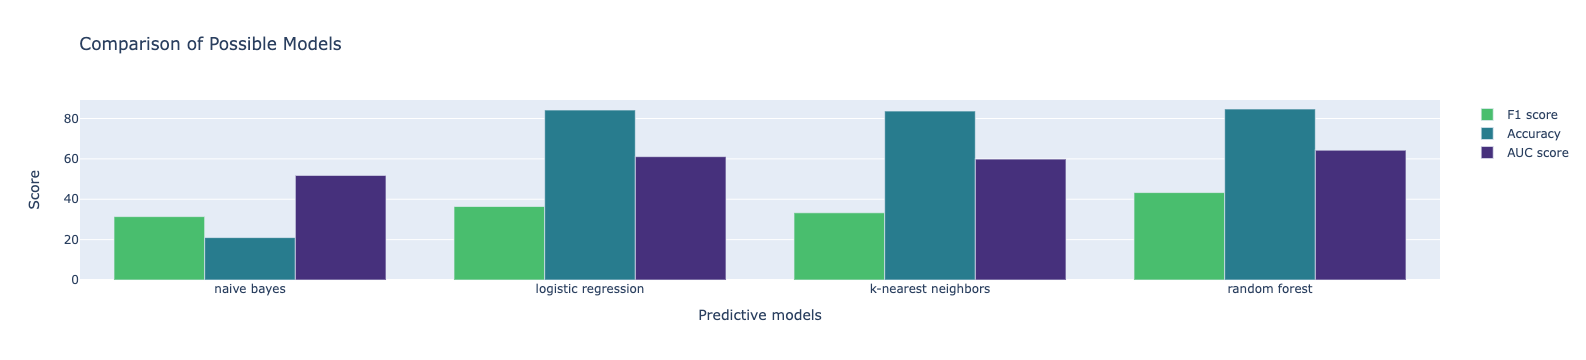

In [408]:
# display comparisions with plotly.
mydata1 = go.Bar(
    x=compare_models.loc['F1 score'].index,
    y=compare_models.loc['F1 score'],
    name=compare_models.index[0],
    marker=dict(color=Viridis[50])
)
mydata2 = go.Bar(
    x=compare_models.loc['Accuracy'].index,
    y=compare_models.loc['Accuracy'],
    name=compare_models.index[1],
    marker=dict(color=Viridis[30])
)
mydata3 = go.Bar(
    x=compare_models.loc['AUC score'].index,
    y=compare_models.loc['AUC score'],
    name=compare_models.index[2],
    marker=dict(color=Viridis[10])
)
mylayout = go.Layout(
    title='Comparison of Possible Models',
    xaxis = dict(title = 'Predictive models'), # x-axis label
    yaxis = dict(title = 'Score'), # y-axis label
    
)
fig = go.Figure(data=[mydata1, mydata2, mydata3], layout=mylayout)
fig

In [409]:
# Create regularization penalty space (l1=ridge, l2=lasso)
penalty = ['l1', 'l2'] 

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, max_iter=[3000])

# Create grid search using 5-fold cross validation
grid_lr = GridSearchCV(LogisticRegression(), hyperparameters, cv=5,  n_jobs = 1, verbose=0)
grid_lr.fit(X_train, y_train)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/studio-lab-user/.conda/envs/default/lib/pyt

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'max_iter': [3000], 'penalty': ['l1', 'l2']})

In [410]:
# Predict on the testing data

predictions=log_model.predict(X_test)
probabilities = log_model.predict_proba(X_test)[:,1]

In [411]:
# Pickle the final model for use in the plotly dash app.
file = open('resources/final_logreg_model_cust.pkl', 'wb')
pickle.dump(log_model, file)
file.close()

# Final Model Metrics


In [412]:
# Full list of metrics
def model_metrics(y_test, predictions):
    '''
    Calculate 5 standard model metrics
    Return a dictionary with the metrics
    '''
    f1 = metrics.f1_score(y_test, predictions)
    accuracy = metrics.accuracy_score(y_test, predictions)
    error = 1 - accuracy
    precision = metrics.precision_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions)
    rocauc =  metrics.roc_auc_score(y_test, predictions)
    return {'precision': precision, 'recall': recall,'f1 score':f1, 'accuracy': accuracy, 'error rate': error,  'ROC-AUC': rocauc}

eval_scores=model_metrics(y_test, predictions)
eval_scores

{'precision': 0.6666666666666666,
 'recall': 0.25,
 'f1 score': 0.36363636363636365,
 'accuracy': 0.8419864559819413,
 'error rate': 0.15801354401805867,
 'ROC-AUC': 0.6112258953168044}

In [413]:
# Round the y values.
y_vals=[]
for val in list(eval_scores.values()):
    y_vals.append(round(float(val*100),1))
y_vals    
# Write over the previous dictionary with the rounded values.
eval_scores=dict(zip(eval_scores.keys(), y_vals))
print(eval_scores)

{'precision': 66.7, 'recall': 25.0, 'f1 score': 36.4, 'accuracy': 84.2, 'error rate': 15.8, 'ROC-AUC': 61.1}


In [414]:
# Now save that dictionary to a pickle file, for later use in plotly dash app
file = open('resources/eval_scores_cust.pkl', 'wb')
pickle.dump(eval_scores, file)
file.close()

In [415]:
# And here's a reminder of how to read that back in again, just in case this is unfamiliar:
file = open('resources/eval_scores_cust.pkl', 'rb')
evals=pickle.load(file)
file.close()
evals

{'precision': 66.7,
 'recall': 25.0,
 'f1 score': 36.4,
 'accuracy': 84.2,
 'error rate': 15.8,
 'ROC-AUC': 61.1}

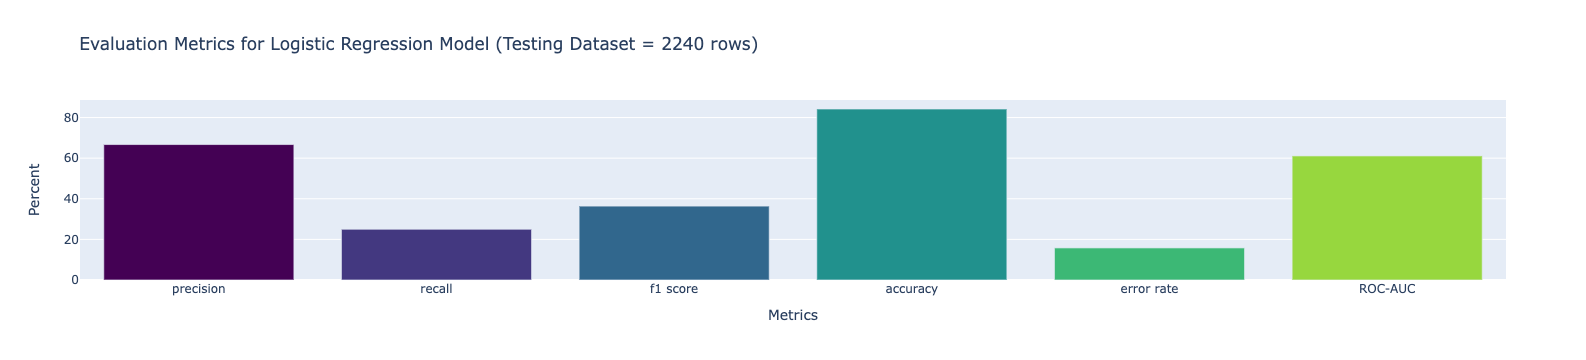

In [416]:
# Convert that into a visualization.
mydata = [go.Bar(
    x=list(evals.keys()),
    y=list(evals.values()),
    marker=dict(color=Viridis[::12])
)]

mylayout = go.Layout(
    title='Evaluation Metrics for Logistic Regression Model (Testing Dataset = 2240 rows)',
    xaxis = {'title': 'Metrics'},
    yaxis = {'title': 'Percent'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [417]:
FPR, TPR, _ = roc_curve(y_test, probabilities)
FPR

array([0.        , 0.00275482, 0.00275482, 0.00275482, 0.00275482,
       0.00550964, 0.00550964, 0.00826446, 0.00826446, 0.01101928,
       0.01101928, 0.0137741 , 0.0137741 , 0.01652893, 0.01652893,
       0.02203857, 0.02203857, 0.02479339, 0.02479339, 0.02479339,
       0.02479339, 0.02754821, 0.02754821, 0.03030303, 0.03030303,
       0.03856749, 0.03856749, 0.04132231, 0.04132231, 0.04407713,
       0.04407713, 0.04683196, 0.04683196, 0.05785124, 0.06060606,
       0.06060606, 0.06336088, 0.06336088, 0.07438017, 0.07438017,
       0.07988981, 0.07988981, 0.08264463, 0.08264463, 0.08539945,
       0.08539945, 0.09366391, 0.09366391, 0.09917355, 0.09917355,
       0.10192837, 0.10192837, 0.1046832 , 0.1046832 , 0.10743802,
       0.10743802, 0.11294766, 0.12121212, 0.12396694, 0.12396694,
       0.12672176, 0.13774105, 0.14325069, 0.15151515, 0.15426997,
       0.15426997, 0.15702479, 0.15977961, 0.16804408, 0.184573  ,
       0.184573  , 0.19008264, 0.19834711, 0.20110193, 0.20110

In [418]:
roc_score=round(100*roc_auc_score(y_test, predictions),1)
roc_score

61.1

In [419]:
roc_dict={'FPR':list(FPR), 
          'TPR':list(TPR),
          'y_test':list(y_test), 
          'predictions':[int(i) for i in predictions]
         }

In [420]:
# Save everything we need to reproduce the ROC-AUC figure in plotly dash.
import json
with open('resources/roc_dict_cust.json', 'w') as f:
    json.dump(roc_dict, f)

In [421]:
with open('resources/roc_dict_cust.json') as json_file:
    roc_dict = json.load(json_file)
FPR=roc_dict['FPR']
TPR=roc_dict['TPR']
y_test=pd.Series(roc_dict['y_test'])
predictions=roc_dict['predictions']

In [422]:
# ROC-AUC figure

roc_score=round(100*roc_auc_score(y_test, predictions),1)
trace0=go.Scatter(
        x=FPR, 
        y=TPR,
        mode='lines',
        name=f'AUC: {roc_score}',
        marker=dict(color=Viridis[10])
        )
trace1=go.Scatter(
        x=[0,1], 
        y=[0,1],
        mode='lines',
        name='Baseline Area: 50.0',
    marker=dict(color=Viridis[50])
        )
layout=go.Layout(
    title='Receiver Operating Characteristic (ROC): Area Under Curve',
    xaxis={'title': 'False Positive Rate (100-Specificity)','scaleratio': 1,'scaleanchor': 'y'},
    yaxis={'title': 'True Positive Rate (Sensitivity)'}
    )
data=[trace0, trace1]
fig = dict(data=data, layout=layout)
fig

{'data': [Scatter({
      'marker': {'color': '#46307c'},
      'mode': 'lines',
      'name': 'AUC: 61.1',
      'x': [0.0, 0.0027548209366391185, 0.0027548209366391185,
            0.0027548209366391185, 0.0027548209366391185, 0.005509641873278237,
            0.005509641873278237, 0.008264462809917356, 0.008264462809917356,
            0.011019283746556474, 0.011019283746556474, 0.013774104683195593,
            0.013774104683195593, 0.01652892561983471, 0.01652892561983471,
            0.02203856749311295, 0.02203856749311295, 0.024793388429752067,
            0.024793388429752067, 0.024793388429752067, 0.024793388429752067,
            0.027548209366391185, 0.027548209366391185, 0.030303030303030304,
            0.030303030303030304, 0.03856749311294766, 0.03856749311294766,
            0.04132231404958678, 0.04132231404958678, 0.0440771349862259,
            0.0440771349862259, 0.046831955922865015, 0.046831955922865015,
            0.05785123966942149, 0.06060606060606061, 0.060

In [423]:
# A confusion matrix tells us our false positives and false negatives:
matrix=confusion_matrix(y_test, predictions)
print(matrix)
cm=pd.DataFrame(matrix, columns=['pred: ignored', 'pred: responded'])
cm[f'n={len(y_test)}']=['actual: ignored', 'actual: responded']
cm=cm[[f'n={len(y_test)}', 'pred: ignored', 'pred: responded']]
cm

[[353  10]
 [ 60  20]]


,n=443,pred: ignored,pred: responded
0,actual: ignored,353,10
1,actual: responded,60,20


In [424]:
# Save cm dataframe to a pickle file, for later use in plotly dash app
cm.to_csv('resources/confusion_matrix_cust.csv', index=False)
cm=pd.read_csv('resources/confusion_matrix_cust.csv')
cm

,n=443,pred: ignored,pred: responded
0,actual: ignored,353,10
1,actual: responded,60,20


In [425]:
# Display the confusion matrix as a formatted table with Plotly
trace = go.Table(
    header=dict(values=cm.columns,
                line = dict(color='#7D7F80'),
                fill = dict(color=Viridis[55]),
                align = ['left'] * 5),
    cells=dict(values=[cm[f'n={len(y_test)}'], cm['pred: ignored'], cm['pred: responded']],
               line = dict(color='#7D7F80'),
               fill = dict(color='white'),
               align = ['left'] * 5))

layout = go.Layout(
    title = f'Confusion Matrix: Logistic Regression Model (Testing Dataset)'
)

data = [trace]
fig = dict(data=data, layout=layout)
fig

{'data': [Table({
      'cells': {'align': [left, left, left, left, left],
                'fill': {'color': 'white'},
                'line': {'color': '#7D7F80'},
                'values': [['actual: ignored', 'actual: responded'], [353, 60], [10,
                           20]]},
      'header': {'align': [left, left, left, left, left],
                 'fill': {'color': '#6bcc5a'},
                 'line': {'color': '#7D7F80'},
                 'values': array(['n=443', 'pred: ignored', 'pred: responded'], dtype=object)}
  })],
 'layout': Layout({
     'title': {'text': 'Confusion Matrix: Logistic Regression Model (Testing Dataset)'}
 })}

In [426]:
# Feature importance (Logistic Regression)
coeffs1=pd.DataFrame(list(zip(list(X_train.columns), logreg.coef_[0])), columns=['feature', 'coefficient'])
coeffs=coeffs1.sort_values(by='coefficient', ascending=False)

# Format the coefficients.
y_vals=[]
for val in list(coeffs['coefficient']):
    y_vals.append(round(float(val),2))
y_vals

coeffs['coefficient']=y_vals
coeffs

,feature,coefficient
1,PriorCampaign,1.74
22,"NumWebVisitsMonth (5, 10]",1.30
20,"MntSpent (1800, 2600]",0.78
8,PostGraduate,0.58
25,CustYrsMoreThan7,0.52
13,"Income (75000, 670000]",0.33
9,"Income (1, 10000]",0.33
19,"MntSpent (1200, 1800]",0.23
26,"NumPurchases (0, 25]",0.19
14,"Recency (0, 35]",0.07


In [427]:
# save the results to a csv file, for later use by plotly dash app.
coeffs.to_csv('resources/coefficients_cust.csv', index=False)

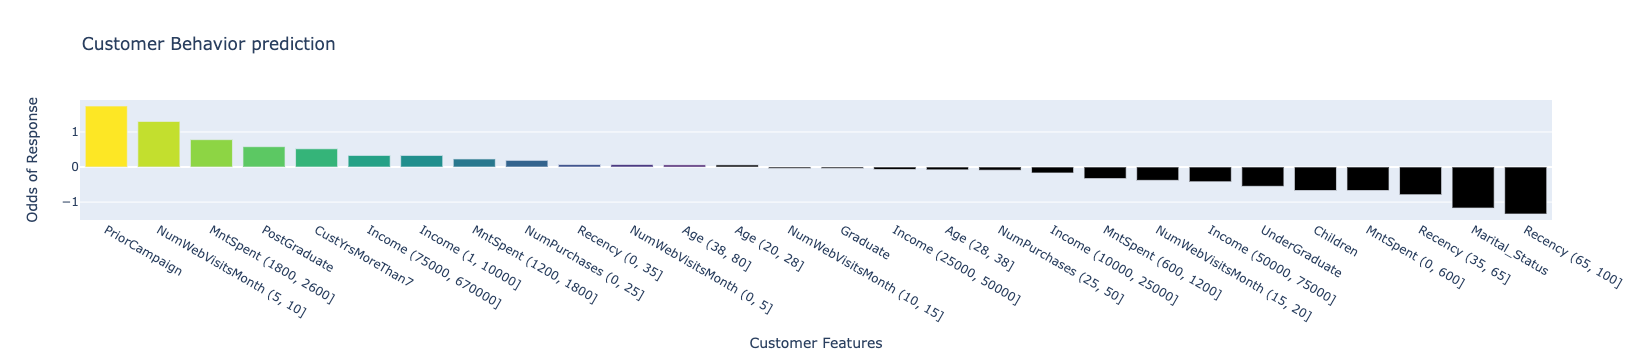

In [428]:
# Let's display that with Plotly.
mydata = [go.Bar(
    x=coeffs['feature'],
    y=coeffs['coefficient'],
    marker=dict(color=Viridis[::-6])
)]

mylayout = go.Layout(
    title='Customer Behavior prediction',
    xaxis = {'title': 'Customer Features'},
    yaxis = {'title': 'Odds of Response'}, 

)
fig = go.Figure(data=mydata, layout=mylayout)
fig

In [431]:
print(len(probabilities))
print(len(predictions))
print(len(y_test))
print(len(X_test))

443
443
443
443


In [432]:
X_test1=X_test1.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)
probs=pd.DataFrame(probabilities, columns=['response_prob'])

In [433]:
# Merge back in the names
final=pd.concat([X_test1, y_test, probs], axis=1)
final.rename(columns={0: "Responded"},inplace=True)

In [434]:
final.shape

(443, 31)

In [435]:
final.head()

,ID,Marital_Status,PriorCampaign,Children,"Age (20, 28]","Age (28, 38]","Age (38, 80]",UnderGraduate,Graduate,PostGraduate,...,"MntSpent (1800, 2600]","NumWebVisitsMonth (0, 5]","NumWebVisitsMonth (5, 10]","NumWebVisitsMonth (10, 15]","NumWebVisitsMonth (15, 20]",CustYrsMoreThan7,"NumPurchases (0, 25]","NumPurchases (25, 50]",Responded,response_prob
0,9353,0,1,1,0,0,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0.162350
1,8749,1,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0.005265
2,10770,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0.008873
3,5954,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0.112213
4,5043,1,0,0,0,0,1,1,0,0,...,0,0,1,0,0,1,1,0,0,0.024196


In [436]:
final.to_csv('resources/final_probs_cust.csv', index=False)

In [437]:
list(final.columns)

['ID',
 'Marital_Status',
 'PriorCampaign',
 'Children',
 'Age (20, 28]',
 'Age (28, 38]',
 'Age (38, 80]',
 'UnderGraduate',
 'Graduate',
 'PostGraduate',
 'Income (1, 10000]',
 'Income (10000, 25000]',
 'Income (25000, 50000]',
 'Income (50000, 75000]',
 'Income (75000, 670000]',
 'Recency (0, 35]',
 'Recency (35, 65]',
 'Recency (65, 100]',
 'MntSpent (0, 600]',
 'MntSpent (600, 1200]',
 'MntSpent (1200, 1800]',
 'MntSpent (1800, 2600]',
 'NumWebVisitsMonth (0, 5]',
 'NumWebVisitsMonth (5, 10]',
 'NumWebVisitsMonth (10, 15]',
 'NumWebVisitsMonth (15, 20]',
 'CustYrsMoreThan7',
 'NumPurchases (0, 25]',
 'NumPurchases (25, 50]',
 'Responded',
 'response_prob']

In [448]:
mydata=final.drop(['response_prob'], axis=1)
table=[go.Table(
        header=dict(values=list(mydata.columns)),
        cells=dict(values=list(mydata.loc[5])))]
table

[Table({
     'cells': {'values': [274, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]},
     'header': {'values': [ID, Marital_Status, PriorCampaign, Children, Age (20,
                           28], Age (28, 38], Age (38, 80], UnderGraduate, Graduate,
                           PostGraduate, Income (1, 10000], Income (10000, 25000],
                           Income (25000, 50000], Income (50000, 75000], Income
                           (75000, 670000], Recency (0, 35], Recency (35, 65],
                           Recency (65, 100], MntSpent (0, 600], MntSpent (600,
                           1200], MntSpent (1200, 1800], MntSpent (1800, 2600],
                           NumWebVisitsMonth (0, 5], NumWebVisitsMonth (5, 10],
                           NumWebVisitsMonth (10, 15], NumWebVisitsMonth (15, 20],
                           CustYrsMoreThan7, NumPurchases (0, 25], NumPurchases (25,
                           50], Responded]}
 })]

# Examine Predictions

In [449]:
names=df['ID'].values
names[:5]

array([5524, 2174, 4141, 6182, 5324])

In [451]:
indexs=df['ID'].index.values
indexs[:5]

array([0, 1, 2, 3, 4])

In [452]:
names=df['ID'].values
index=df['ID'].index.values
nameslist = list(zip(indexs, names))
print(nameslist[5])
print(nameslist[5][0])
print(nameslist[5][1])

(5, 7446)
5
7446


In [453]:
options=[{'label': k, 'value': i} for i,k in nameslist]
options[0]

{'label': 5524, 'value': 0}

In [454]:
value=nameslist[0][0]
value

0

In [455]:
responded=final.loc[value, 'response_prob']
round(responded*100)

16

In [456]:
final.columns

Index(['ID', 'Marital_Status', 'PriorCampaign', 'Children', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'UnderGraduate', 'Graduate',
       'PostGraduate', 'Income (1, 10000]', 'Income (10000, 25000]',
       'Income (25000, 50000]', 'Income (50000, 75000]',
       'Income (75000, 670000]', 'Recency (0, 35]', 'Recency (35, 65]',
       'Recency (65, 100]', 'MntSpent (0, 600]', 'MntSpent (600, 1200]',
       'MntSpent (1200, 1800]', 'MntSpent (1800, 2600]',
       'NumWebVisitsMonth (0, 5]', 'NumWebVisitsMonth (5, 10]',
       'NumWebVisitsMonth (10, 15]', 'NumWebVisitsMonth (15, 20]',
       'CustYrsMoreThan7', 'NumPurchases (0, 25]', 'NumPurchases (25, 50]',
       'Responded', 'response_prob'],
      dtype='object')

In [457]:
final.head()

,ID,Marital_Status,PriorCampaign,Children,"Age (20, 28]","Age (28, 38]","Age (38, 80]",UnderGraduate,Graduate,PostGraduate,...,"MntSpent (1800, 2600]","NumWebVisitsMonth (0, 5]","NumWebVisitsMonth (5, 10]","NumWebVisitsMonth (10, 15]","NumWebVisitsMonth (15, 20]",CustYrsMoreThan7,"NumPurchases (0, 25]","NumPurchases (25, 50]",Responded,response_prob
0,9353,0,1,1,0,0,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0.162350
1,8749,1,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0.005265
2,10770,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0.008873
3,5954,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0.112213
4,5043,1,0,0,0,0,1,1,0,0,...,0,0,1,0,0,1,1,0,0,0.024196


In [458]:
testset=final.drop(["response_prob", 'Responded', 'ID'], axis=1)
firstrow=testset.loc[0]
firstrow

Marital_Status                0
PriorCampaign                 1
Children                      1
Age (20, 28]                  0
Age (28, 38]                  0
Age (38, 80]                  1
UnderGraduate                 0
Graduate                      1
PostGraduate                  0
Income (1, 10000]             0
Income (10000, 25000]         0
Income (25000, 50000]         0
Income (50000, 75000]         1
Income (75000, 670000]        0
Recency (0, 35]               0
Recency (35, 65]              1
Recency (65, 100]             0
MntSpent (0, 600]             0
MntSpent (600, 1200]          1
MntSpent (1200, 1800]         0
MntSpent (1800, 2600]         0
NumWebVisitsMonth (0, 5]      1
NumWebVisitsMonth (5, 10]     0
NumWebVisitsMonth (10, 15]    0
NumWebVisitsMonth (15, 20]    0
CustYrsMoreThan7              1
NumPurchases (0, 25]          1
NumPurchases (25, 50]         0
Name: 0, dtype: int64

In [459]:
myarray=firstrow.values
myarray.shape

(28,)

In [460]:
thisarray=myarray.reshape((1, myarray.shape[0]))
thisarray.shape

(1, 28)

In [461]:
logreg.predict_proba(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array([[0.8376502, 0.1623498]])

In [463]:
result=logreg.predict(thisarray)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



In [464]:
result

array([0])

In [353]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency', 'NumWebVisitsMonth',
       'Response', 'Yrs_Customer', 'age', 'MntSpent', 'PriorCampaign',
       'NumPurchases', 'Children', 'Age (1, 20]', 'Age (20, 28]',
       'Age (28, 38]', 'Age (38, 80]', 'UnderGraduate', 'Graduate',
       'PostGraduate', 'Income (1, 10000]', 'Income (10000, 25000]',
       'Income (25000, 50000]', 'Income (50000, 75000]',
       'Income (75000, 670000]', 'Recency (0, 35]', 'Recency (35, 65]',
       'Recency (65, 100]', 'MntSpent (0, 600]', 'MntSpent (600, 1200]',
       'MntSpent (1200, 1800]', 'MntSpent (1800, 2600]',
       'NumWebVisitsMonth (0, 5]', 'NumWebVisitsMonth (5, 10]',
       'NumWebVisitsMonth (10, 15]', 'NumWebVisitsMonth (15, 20]',
       'CustYrsMoreThan7', 'NumPurchases (0, 25]', 'NumPurchases (25, 50]'],
      dtype='object')